# Transfer Learning of Deep Neural Networks using CNN models
**Notebook 2 of 2**

In our previous tutorials, we explored various machine learning and deep learning algorithms trained for specific tasks. Each model had to be rebuilt from scratch when data or features changed. The concept of transfer learning improves on this by utilizing existing knowledge solve related but essentially new problems. In other words, we use what has been learned in one setting to improve generalization in another setting.<br>
In this tutorial, we will initially use the dogs vs cats dataset from Kaggle at the following link: [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats/data) which is an archive containing 25,000 images of dogs and cats. In the second case, we will do tranfer learning using the VGG-16 pre-trained model created by the University of Oxford.<br>

## Learning Objectives

Average time to complete: 75min

By the end of this tutorial you should be able to:
* Apply notions from DNN and CNN.
* Learn how to implement the benefits of transfer learning
* Understand the inner workings of CNN models and transfer learning for fine tuning.
* Explore and analyze two transfer learning use cases: 1) Image classification with raw data, 2) Image classification using a pre-trained model

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* This notebooks runs best on a server with GPU and 8GB RAM.  The Alliance server provide Nvidia V100 and A100 GPUs which work fine.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* Tensorflow
* We will use scikit learn as our machine learning package.
* numpy 
* seaborn 
* matplotlib
* requests
* ipywidgets
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Managment (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial. 

Let's first check to see that we have access to the GPU

In [7]:
!nvidia-smi

Tue Apr 23 09:21:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:17:00.0 Off |                    0 |
| N/A   47C    P0              72W / 300W |    427MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

We disable warnings that can slow down the performance of the GPU.  Of couse, we only consider this after debugging the code.

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Add the libraries to our notebook

In [9]:
import glob
import numpy as np
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil
np.random.seed(42)

%matplotlib inline

In [10]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

Here we check to see what compute resources we have access to as well as naming.  This is useful if we want to use some devices for higher compute needs such as /device:GPU:0 or lower compute needs such as /device:CPU:0

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1863230695068200855
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82928992256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17689933891353194774
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


# Image Classification with a relatively small dataset

Working with images, especially in AI models, is very resource intense.

### Building Dataset


Let have a look at the cats vs dogs dataset a prepare our datasets

In [12]:
files = glob.glob('pics_data/train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

Let’s build our smaller dataset, so that we have 350 images for training, 150 images for validation, and 150 images for our test dataset

In [13]:
cat_train = np.random.choice(cat_files, size=350, replace=False)
dog_train = np.random.choice(dog_files, size=350, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=150, replace=False)
dog_val = np.random.choice(dog_files, size=150, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=150, replace=False)
dog_test = np.random.choice(dog_files, size=150, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (350,) (150,) (150,)
Dog datasets: (350,) (150,) (150,)


Write them out to our disk in separate folders

In [14]:
train_dir = 'pics_data/training_data'
val_dir = 'pics_data/validation_data'
test_dir = 'pics_data/test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

### Preparing Dataset

The following code prepares the datasets for doing the transfer learning:
* Find all the files in the training_data folder
* Load and resize each image file to the specified dimensions using load_img and img_to_array.  This is done in RAM
* Convert the list of images to a Numpy array train_imgs
* Extract the labels or classes from the file names and stores them in train_labels.

The resulting train_imgs and train_Labels can be used for training the CNN model whereby train_imgs contains the imgae data, and train_labels contains the corresponding labels or classes.

In [15]:
IMG_DIM = (150, 150)

train_files = glob.glob('pics_data/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[2].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('pics_data/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[2].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (700, 150, 150, 3) 	Validation dataset shape: (300, 150, 150, 3)


We can clearly see that we have 350 training images for dogs and cats (700 total) and 150 validation (300 total). Each image is of size 150 x 150 and has three channels for red, green, and blue (RGB), hence giving each image the (150, 150, 3) dimensions.

In [16]:
#print(train_labels)

In [17]:
#print(validation_labels)

Next, scale each image with pixel values between (0, 255) to values between (0, 1) because deep learning work very well with small input values

(150, 150, 3)


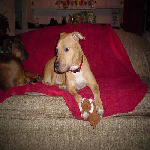

In [20]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

Output shows one of the sample images from our training dataset

We need to configure Keras parameters and also encode our text class labels into numeric values otherwise, Keras will throw an error.

In [21]:
batch_size = 20                      #Indicates the total number of images passed to the model per iteration
num_classes = 2
epochs = 30                          # Indicates number of iterations
input_shape = (150, 150, 3)          # Shape of the images

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)

validation_labels_enc = le.transform(validation_labels)

print(train_labels[14:20], train_labels_enc[14:20])

['cat', 'cat', 'dog', 'cat', 'dog', 'dog'] [0 0 1 0 1 1]


We can see that our encoding scheme assigns the number 0 to the cat labels and 1 to the dog labels. We are now ready to build our first CNN-based deep learning model.

### Simple CNN Model built from scratch

We will start by building a basic CNN model with three convolutional layers, coupled with max pooling for auto-extraction of features from our images and also downsampling the output convolution feature maps.

Let's take a look at the major building blocks of our basic CNN model...<br>
The code is commented to explain the key points in understanding the contruction of the CNN model

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

# Open an instance for the model
model = Sequential()

# Conv2D add a 2D convolutional layer with 16 filters.   
# Each filter is 3x3 pixels in size.  The activation funtion ReLu is applied to the output of this layer. 
# Input shape is the shape of each image - Here it is 150 pixles x 150 pixels x depth of 3.
# We apply max pooling to the layer helps the CNN focus on the most salient features and discard less relevant
# information, leading to better feature representation.
# ReLu is the most computaitonally efficient activation function.  Recall from the DNN workshop that this 
# function allows a model to capture more complex relationships.  
# This enhances the CNN's ability to capture features during the training.

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# These are the final layers of the model.  Flatten reshapes the output from the previous layer into a 1D
# vector.
# Dense add a fully connected layer with 512 neurons and a ReLu activation function.
# The second Dense add the final fully connected layer with 1 neuron and a sigmoid activation function. This
# layer produces the binary output (0, 1), (cat, dog) for the classification task
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()



'''
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               18940416  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
=================================================================
Total params: 19,024,513
Trainable params: 19,024,513
Non-trainable params: 0
_________________________________________________________________
'''


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,024,513 (72.57 MB)

 Trainable params: 19,024,513 (72.57 MB)

 Non-trainable params: 0 (0.00 B)

"\n'''\nLayer (type)                 Output Shape              Param #   \n=================================================================\nconv2d_1 (Conv2D)            (None, 148, 148, 16)      448       \n_________________________________________________________________\nmax_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         \n_________________________________________________________________\nconv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      \n_________________________________________________________________\nmax_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         \n_________________________________________________________________\nconv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     \n_________________________________________________________________\nmax_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         \n_________________________________________________________________\nflatten_1 (Flatten)          (None, 36992)            

model.summary() helps us track the input data as it passes through the various layers of the CNN. An output shape of (None, 148, 148, 16) means the layer produced an output tensor of variable batch size, height and width of 148 pixels and 16 feature maps. The later layer has 128 features of abstraction which means that the CNN model is using 128 features to classify an image passed to it.

We use a batch_size of 30.  If our training data has a total of 350 samples, which indicates that there will be a total of 12 iterations per epoch. We train the model for a total of 30 epochs and validate it consequently on our validation set of 150 images.<br>
An epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches.

The line below lauched the training of the model

In [25]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30


I0000 00:00:1713879967.802470   16549 service.cc:145] XLA service 0x2b8b80042230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713879967.803726   16549 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0


21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4934 - loss: 2.4293

I0000 00:00:1713879979.745196   16549 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.4972 - loss: 1.9591 - val_accuracy: 0.5000 - val_loss: 0.6900
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5187 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5533 - loss: 0.6896 - val_accuracy: 0.5900 - val_loss: 0.6747
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6178 - loss: 0.6697 - val_accuracy: 0.6567 - val_loss: 0.6265
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6388 - loss: 0.6617 - val_accuracy: 0.6367 - val_loss: 0.6024
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6621 - loss: 0.6219 - val_accuracy: 0.6900 - val_loss: 0.5989
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7455 - loss: 0.5211 - val_accuracy: 0.6833 - val_loss: 0.6160
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7720 - loss: 0.4698 - val_accuracy: 0.6900 - val_loss: 0.5952
E

Here we plot the accuracy and loss data for each epoch to get an idea of the model's performance

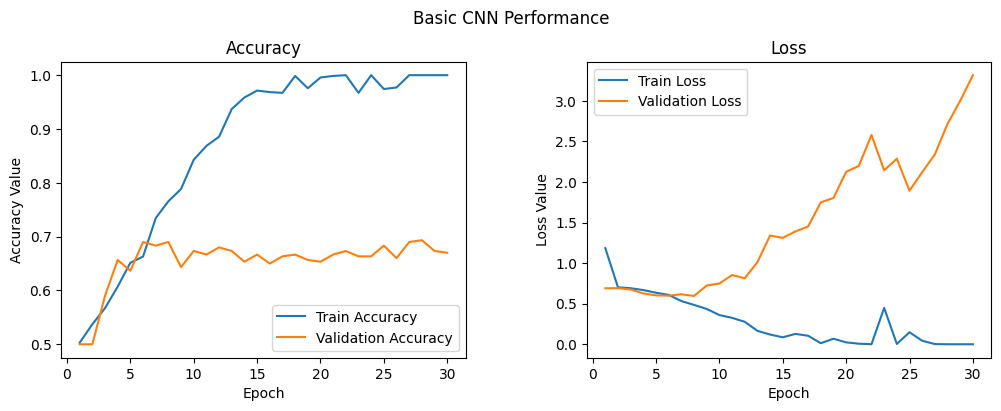

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Accuracy and Loss between training and validation are diverging.  This is a distinct sign of overfitting as the model is able to "generalize" enough to properly identify an unseen image.

# Regularization of CNN models

Regularization methods for CNNs are commonly used to reduce overfitting.  L1 and L2 regularization, also known as weight decay, ridge or lasso regularization, add a term to the loss function that lenalizes large weights in the model.  L1 tends to make some weights zero, while L2 make all weight smaller.

Dropout is a technique that randomly drops out some units or neurons in the hidden layers during training, preventing co-adaptation (strong correlation) of features. This helps the model learn from different perspectives and variations of the data.

In our example, Dropout randomly masks the outputs of a fraction of units from a layer by setting their output to zero (it is 30% of the units in our dense layers).

In [27]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Epoch 1/30
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4795 - loss: 0.9366

I0000 00:00:1713880019.631832   16549 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 4 bytes spill stores, 4 bytes spill loads



35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.4797 - loss: 0.9274 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5091 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5365 - loss: 0.7126 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5350 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4993 - loss: 0.6950 - val_accuracy: 0.5067 - val_loss: 0.6922
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5186 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6856
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5579 - loss: 0.6905 - val_accuracy: 0.6100 - val_loss: 0.6651
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6212 - loss: 0.6740 - val_accuracy: 0.6067 - val_loss: 0.6478


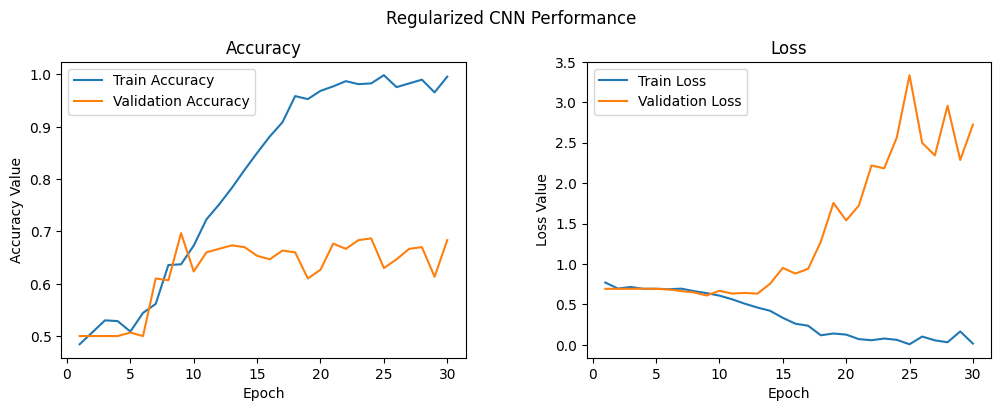

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularized CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Overfitting of model shown by divergence of validation and training loss.  The model is unable to generalize enough to properly identify data that hasn't been "seen" before.

## CNN Model with Image Augmentation

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


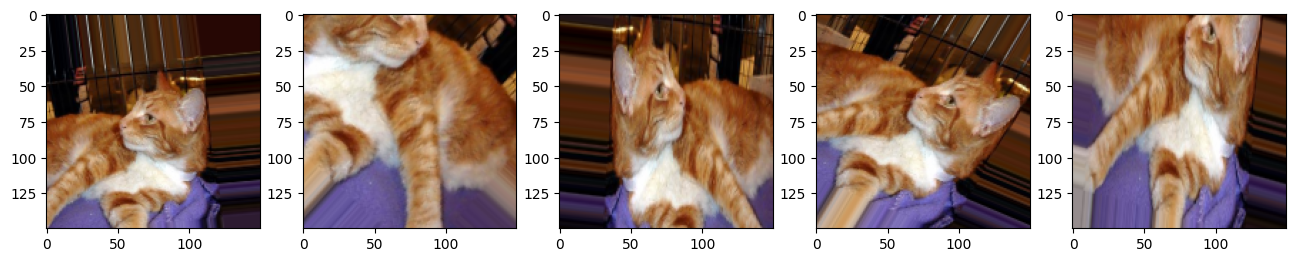

In [30]:
img_id = 15
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
#print(cat[0])
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


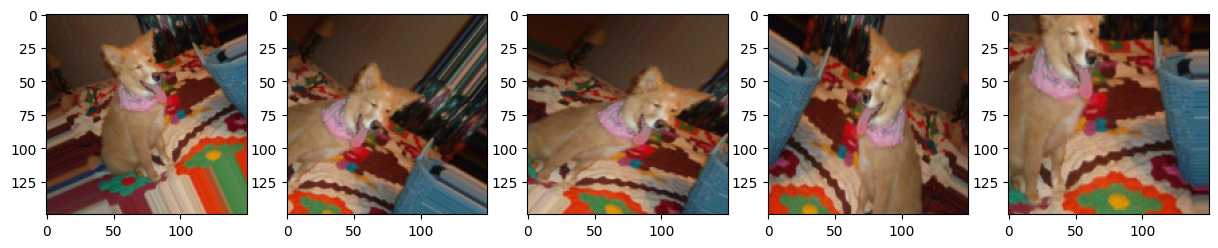

In [31]:
img_id = 250
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [32]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=25)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

In [33]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,113 (14.14 MB)

 Trainable params: 3,706,113 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#history = model.fit(train_generator, steps_per_epoch=50, epochs=50, validation_data=val_generator, validation_steps=50, verbose=1)
history = model.fit(train_generator, epochs=70, validation_data=val_generator, validation_steps=70, verbose=1)

Epoch 1/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.5303 - loss: 0.6925 - val_accuracy: 0.5367 - val_loss: 0.6913
Epoch 2/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5357 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6887
Epoch 3/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5058 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6864
Epoch 4/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5307 - loss: 0.6921 - val_accuracy: 0.5067 - val_loss: 0.6833
Epoch 5/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5432 - loss: 0.6900 - val_accuracy: 0.5000 - val_loss: 0.6818
Epoch 6/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5285 - loss: 0.6880 - val_accuracy: 0.5500 - val_loss: 0.6773
Epoch 7/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5658 - loss: 0.6821 - val_accuracy: 0.5600 - val_loss: 0.6732
Epoch 8/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5558 - loss: 0.6849 - val_accuracy: 0.5133 - v

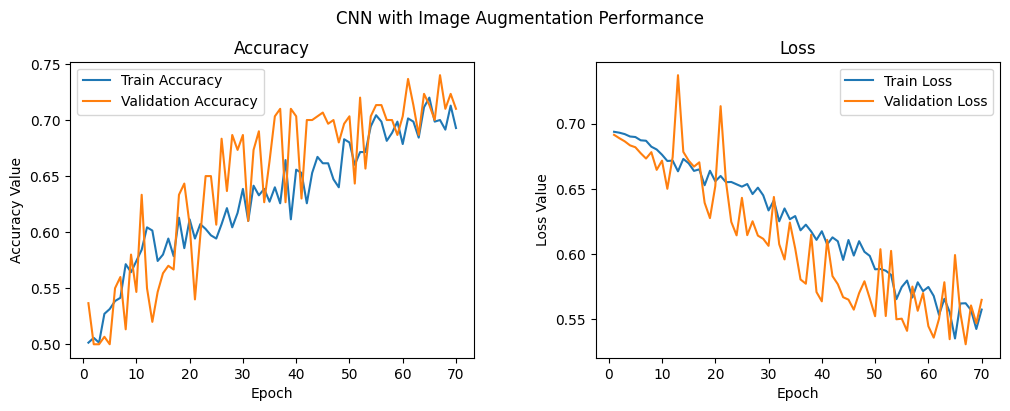

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We notice that validation accuracy is much closer to training accuracy.  The two aren't diverging indicating that there is little overfitting and we have a model that generalizes much better as compared to our previous models.

Save the model

In [36]:
# model is saved
model.save('cats_dogs_basic.h5')

# VGG-16 Pre-trained model


VGG-16 is a model that was already trained on a very large dataset (ImageNet) with many different types of images. It learned important patterns or "features" from the images in a way that doesn't change if the image is moved, or parts of it are in different positions.<br>
Since VGG-16 was trained on over a million image from 1000 categories, it understands what make images different in a good way. Even if new images are totally new and not in ImageNet, VGG-16 can still pick out important parts of the new images that help describe what is in them.<br>
Because VGG-16 learned such good features from lots of data, we can use it to extract or pick out features from new images, even if they are different categories. This makes VGG-16 useful for computer vision problems on new, unseen images too.

Using Keras, we will load the VGG-16 model, and freeze the convolution blocks so that we can use it as just an image feature extractor.

In [37]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_5, built=True>",input_layer_5,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


We see that none of the layers are trainable (shown by False).  This is the result we want since we want VGG-16 to keep the features it already learned from ImageNet.  "block5_pool" are the bottleneck features as they are located right before the classification head of the network, so their outputs contain highly discriminative features for the original classification task.  It's more efficient to do it this way rather than from every layer as they provide a compressed latent space representation of the input.

The following shows what the bottleneck features look like for a sample image from our training data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
(1, 4, 4, 512)


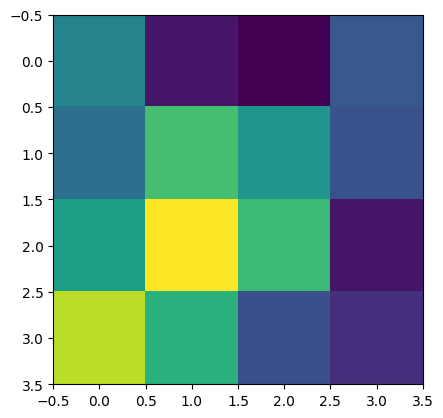

In [38]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [39]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (700, 8192) 	Validation Bottleneck Features: (300, 8192)


This confirms we have extracted the bottleneck features.<br>
Now let's build the model based on those features.

In [40]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,457,985 (17.01 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5763 - loss: 0.6914 - val_accuracy: 0.8300 - val_loss: 0.3956
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.3584 - val_accuracy: 0.8533 - val_loss: 0.3134
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3098 - val_accuracy: 0.8400 - val_loss: 0.3286
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.3142 - val_accuracy: 0.8400 - val_loss: 0.3517
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9462 - loss: 0.1749 - val_accuracy: 0.8933 - val_loss: 0.2675
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.1394 - val_accuracy: 0.8467 - val_loss: 0.3105
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.1278 - val_accuracy: 0.8467 - val_loss: 0.3182
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.1518 - val_accuracy: 0.8900 - val_loss

In [42]:
model.save('cats_dogs_vgg16.h5')

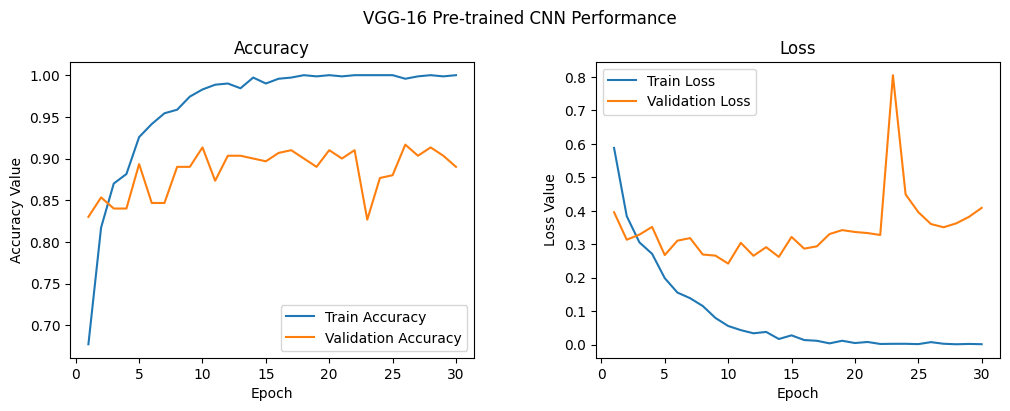

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We get a validation accuracy in the higher 80s. That over 20% increase over the basic model with the raw data.  Also, there isn't any overfitting.  The gap between training and validation is fairly large which tells us there could be a significant amount of overfitting on the training data.  Overall, it's a very good result.

### Pre-trained CNN model as a Feature Extractor with Image Augmentation

These are the same data generators as before.

In [44]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

As explained with Regularization of CNN models at the begining of the tutorial, dropout is a technique that randomly drops out some units or neurons in the hidden layers during training, preventing co-adaptation (strong correlation) of features. This helps the model learn from different perspectives and variations of the data.
In our example, Dropout randomly masks the outputs of a fraction of units from a layer by setting their output to zero (it is 30% of the units in our dense layers).


In [45]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
              
history = model.fit(train_generator, steps_per_epoch=70, epochs=70,
                              validation_data=val_generator, validation_steps=70, 
                              verbose=1) 

Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.5621 - loss: 0.7025 - val_accuracy: 0.6167 - val_loss: 0.6292
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5902 - loss: 0.6648 - val_accuracy: 0.6867 - val_loss: 0.5894
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6428 - loss: 0.6382 - val_accuracy: 0.7867 - val_loss: 0.5476
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6292 - loss: 0.6388 - val_accuracy: 0.7900 - val_loss: 0.5205
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6584 - loss: 0.6141 - val_accuracy: 0.8333 - val_loss: 0.4861
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6959 - loss: 0.5864 - val_accuracy: 0.8400 - val_loss: 0.4600
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6977 - loss: 0.5741 - val_accuracy: 0.8500 - val_loss: 0.4344
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7048 - loss: 0.5681 - val_accuracy: 0.8267 

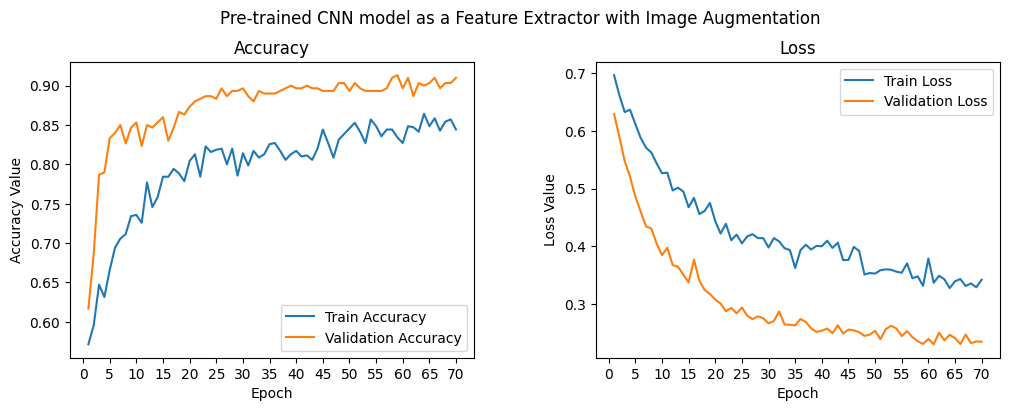

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model as a Feature Extractor with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Pre-trained CNN model with Fine-tuning and Image Augmentation


In [47]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_5, built=True>",input_layer_5,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


In [48]:
tf.keras.backend.clear_session()

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
           

history = model.fit(train_generator, steps_per_epoch=70, epochs=70,
                              validation_data=val_generator, validation_steps=70, 
                              verbose=1)

Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5087 - loss: 0.7242 - val_accuracy: 0.7833 - val_loss: 0.5982
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6177 - loss: 0.6407 - val_accuracy: 0.8133 - val_loss: 0.4986
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7012 - loss: 0.5840 - val_accuracy: 0.8433 - val_loss: 0.4255
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7566 - loss: 0.5168 - val_accuracy: 0.8033 - val_loss: 0.4248
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7873 - loss: 0.4645 - val_accuracy: 0.8867 - val_loss: 0.2904
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8093 - loss: 0.4210 - val_accuracy: 0.8967 - val_loss: 0.2703
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8307 - loss: 0.4036 - val_accuracy: 0.9133 - val_loss: 0.2439
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8137 - loss: 0.3702 - val_accuracy: 0.9367 - 

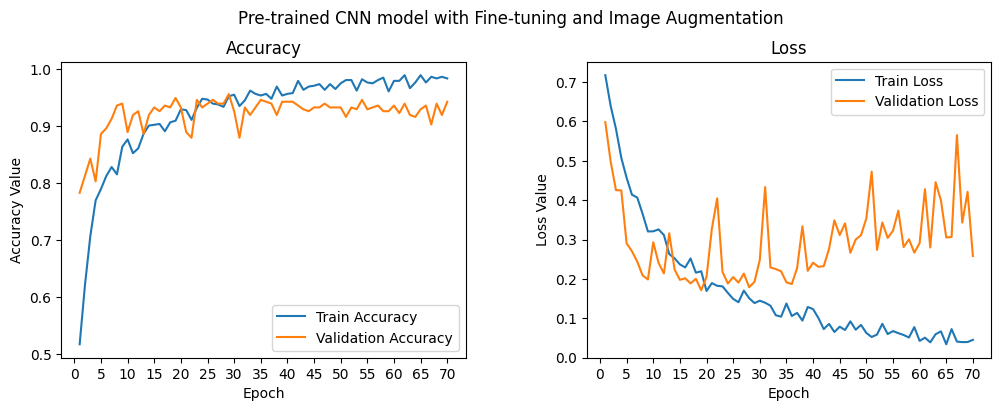

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model with Fine-tuning and Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")